# 1- DCGAN Challenge


## Installing and importing libraries and data

In [1]:
!pip  install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time

from IPython import display

import medmnist
from medmnist import INFO

from geo_augmentation import  geo_aug
from VAE_model import CVAE, compute_loss, log_normal_pdf, train_step_VAE, generate_images
from DCGAN_training import train, train_step, generate_and_save_images


## Loading and processing the data.

Taking the Pneumonia dataset from the medmnist 2D datasets:

In [3]:
data_flag = 'pneumoniamnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', download=True)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


### Separating data: have pneumonia or not

In [4]:
pneumonia=[]
healthy=[]
for i in range(len(train_dataset)):
  if train_dataset[i][1][0]==0:
    pneumonia.append(train_dataset[i][0])
  else:
    healthy.append(train_dataset[i][0])

### Looking at the data

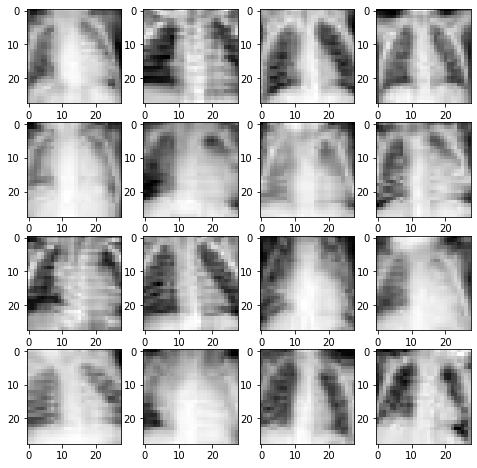

In [5]:
imgs=[]
for i in range (0,16):
  imgs.append(test_dataset[i][0])

_, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img,cmap='gray')
plt.show()

### Simplifying data 
Into numpy arrays to comply with tensorflow.<br>
Reshaping, normalizing, and batching data.

In [6]:
tra=[]
labels=np.ones(len(pneumonia))
for i in range (0,len(pneumonia)):
    tra.append(np.array(pneumonia[i]))
tra=np.array(tra)

train_images = tra.reshape(tra.shape[0], 28, 28, 1).astype('float32')
norm=np.max(train_images)/2
train_images = (train_images - norm) / norm  # Normalize the images to [-1, 1]
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



## Training, Generating and saving images

### 1- Pneumonia cases

Let's train our GAN network and track the progress visually

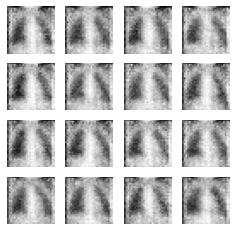

In [7]:
train(train_dataset, 300,case='pneumonia')

### 2- Healthy cases

In [8]:
#We take the data of healthy lungs and retrain
tra=[]
labels=np.ones(len(healthy))
for i in range (0,len(healthy)):
    tra.append(np.array(healthy[i]))
tra=np.array(tra)

train_images = tra.reshape(tra.shape[0], 28, 28, 1).astype('float32')
norm=np.max(train_images)/2
train_images = (train_images - norm) / norm  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

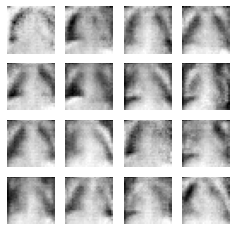

In [9]:
train(train_dataset, 300,case='healthy')

# 2- VAE replicata

## Importing and prepapring data

In [10]:
#Similarly to what we did before, we load and transform the data
data_flag = 'pneumoniamnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', download=True)

te=DataClass(split='test')
tes=[]
te_labels=np.zeros(len(te))
for i in range (0,len(te)):
    te_labels[i]=int(te[i][1])
    tes.append(np.array(te[i][0]))
tes=np.array(tes)
test_labels=te_labels


tr=DataClass(split='train')
tra=[]
labels=np.zeros(len(tr))
for i in range (0,len(tr)):
    labels[i]=int(tr[i][1])
    tra.append(np.array(tr[i][0]))
tra=np.array(tra)
train_labels=labels


BATCH_SIZE = 256
BUFFER_SIZE = 50000


train_images = tra.reshape(tra.shape[0], 28, 28, 1).astype('float32')
test_images = tes.reshape(tes.shape[0], 28, 28, 1).astype('float32')

norm=np.max(train_images)/2
train_images = (train_images - norm) / norm  # Normalize the images to [-1, 1]
test_images = (test_images - norm) / norm  # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


## Modeling

In [11]:
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 2  # set the dimensionality of the latent space to a plane for visualization later
num_examples_to_generate = 16

test_size = len(test_dataset)
batch_size = 64
train_size = len(train_dataset)
model = CVAE(latent_dim)
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])


# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  

## Training

Epoch: 9, time elapse for current epoch: 201.9914093017578


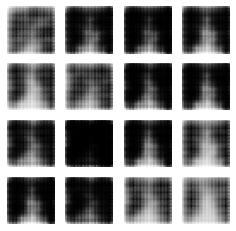

In [12]:
generate_images(model, 0, test_sample)

for epoch in range(1, 10):
  start_time = time.time()
  for train_x in train_dataset:
    train_step_VAE(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_images(model, epoch, test_sample)

# 3- Geometrical voodoo

### Reloading and preparing the data

In [13]:
train_dataset = DataClass(split='train', download=True)
tra=[]
labels=np.ones(len(train_dataset))
for i in range (0,len(train_dataset)):
    tra.append(np.array(train_dataset[i][0]))
tra=np.array(tra)

train_images = tra.reshape(tra.shape[0], 28, 28, 1).astype('float32')

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


### Generating data

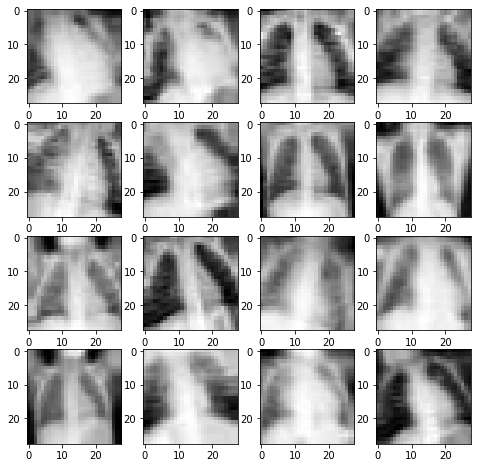

In [14]:
datagen=geo_aug(train_images,test_images)

# Conclusion

* The model can create accurate images with more training.<br>
* The data can be used as Data augmentation in future classification tasks to improve the model. <br>
* VAE model overfits very quickly on our datasaet. <br>
* The geometric data augmentation, although limited, can also help us increase the classification accuracy.
